## Intro to AI Assignment 2: Predicting the popularity (retweets) of COVID-19 related tweets
### Audrey Zhang
### October 2020

Answers to assignment questions:

2c: The plots show that the # of followers and # of friends for the tweets in the dataset are normally distributed. The # of favorites is also somewhat similar to a normal distribution, but has a second peak at 0. This is likely caused by the large number of tweets that only had 0-1 favorites. 

The corelation matrix signifies that the # of favorites on a tweet is most highly correlated with the tweet's popularity (# retweet), with a correlation coefficient of 0.89. This is followed by the # of followers with a correlation coefficient of 0.13. 

2d: The +/- signs indicate the direction of the correlation. + indicates positive correlation. For example, a higher # of favorites is correlated with a higher # of retweets. In contrast, - indicates negative correlation. An increase in the negative sentiment score is correlated with a lower # of retweets.

2e: If a feature shows 0 correlation with #Retweets, it means it is not linearly correlated wth the dependent variable (retweets). However, it can still contribute to the prediction as a control variable. This helps reduce the potential for omitted variable bias in the model. There may also be interaction/confounding effects between the predictor variables that need to be accounted for in the prediction model. 

6: Among the various models tried and the two datasets used (one with 'full' features (i.e. with addtional features engineered from raw data) and one with reduced features (i.e. with some engineered features combined), an XGBoost tree method has the best score in terms of smallest RMSE. Because the outcome variable here is a continuous variable, other model evaluation metrics like accuracy/precision/recall are less helpful. Additionally, the R-squared value is used to inform how much of the variability in the dependent variable is actually captured by the model. 

The resulting RMSE is 153.73, with an adjusted R-squared value of 67.6. Note that there is one outlier in the data with a significantly outlying number of retweets (>73,000). Removing this observation could theoretically improve the model accuracy (and reduce the RMSE). However, because this observation is a natural part of the data variability and is not caused by errors such as data entry, a decision was made to keep this observation in the data so as not to artifically reduce the data variability.

Additionally, note that the XGBoost tree regression using the reduced dataset had an RMSE of 156.7 and adjusted R-squared of 0.66. This indicates that having the additional features expanded as dummy variables in the full dataset is only marginally more informative for the model than having them combined in the reduced dataset. 

#### Initial data cleaning and feature creation

In [1]:
# import libraries
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import re
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [2]:
tweets=pd.read_csv('./hw2.csv')

In [3]:
tweets.head()

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,Hashtags,URLs
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,null;,2 -1,null;,null;,null;
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,null;,https://twitter.com/himalayahawk/status/117766...
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,null;,null;
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;


In [4]:
# break out sentiment variable into positive and negative
tweets['Positive']=tweets['Sentiment'].str.slice(0, 1).astype(int)
tweets['Negative']=tweets['Sentiment'].str.slice(-2).astype(int)

In [5]:
# analyze the mentions column 
men=tweets['Mentions'].dropna(axis=0).str.split()

In [6]:
# create list of lists for each item in a mention for each tweet 
mentions=[i.strip().upper() for i in list(itertools.chain.from_iterable(men.to_list())) if 'null' not in i]

In [7]:
# create a dictionary to store all mentions that appeared over 10 times
mentions_dict={x: count for x, count in Counter(mentions).items() if count >=10}

In [8]:
# take a look at the highest count mentions (top 10) and store in a list 
top_mentions=sorted(mentions_dict, key=mentions_dict.get, reverse=True)[:10]
top_mentions

['REALDONALDTRUMP',
 'JAKETAPPER',
 'BTS_TWT',
 'POTUS',
 'YOUTUBE',
 'CNN',
 'NBA',
 'SPEAKERPELOSI',
 'GOP',
 'LINDSEYGRAHAMSC']

In [9]:
# analyze the hashtag column
hsh=tweets['Hashtags'].dropna(axis=0).str.split()

In [10]:
hashtags=[i.strip().upper() for i in list(itertools.chain.from_iterable(hsh.to_list())) if 'null' not in i]

In [11]:
hashtags_dict={x: count for x, count in Counter(hashtags).items() if count >=10 and x not in top_mentions}

In [12]:
top_hashtags=sorted(hashtags_dict, key=hashtags_dict.get, reverse=True)[:10]
top_hashtags

['CHINA',
 'HEALTHCARE',
 'HONGKONG',
 'HONGKONGPROTESTS',
 'STANDWITHHONGKONG',
 'CHINAZI',
 'STRONGERTOGETHER',
 'ANTICHINAZI',
 'ANTIMASKLAW',
 'IMPEACHTRUMPPENCEBARRPOMPEO']

In [13]:
# create a variable for the # create variable for # of mentions for each tweet, excluding those that have 'null' in the mentions column
tweets['#Mentions']=tweets[(tweets['Mentions'].isnull()==False) & (tweets['Mentions'].str.contains('null')==False)]['Mentions'].str.split().apply(len)

In [14]:
tweets['#Mentions'].fillna(0, inplace=True)

In [15]:
tweets['#Mentions']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
99995    1.0
99996    1.0
99997    0.0
99998    0.0
99999    0.0
Name: #Mentions, Length: 100000, dtype: float64

In [16]:
# similarly, create # of hashtags for each tweet, excluding those with 'null'
tweets['#Hashtags']=tweets[(tweets['Hashtags'].isnull()==False) & (tweets['Hashtags'].str.contains('null')==False)]['Hashtags'].str.split().apply(len)

In [17]:
tweets['#Hashtags'].fillna(0, inplace=True)

In [18]:
# check for missing values
tweets.isnull().sum()

Tweet ID        0
Username        0
Timestamp       0
#Followers      0
#Friends        0
#Retweets       0
#Favorites      0
Entities        0
Sentiment       0
Mentions      233
Hashtags       31
URLs            0
Positive        0
Negative        0
#Mentions       0
#Hashtags       0
dtype: int64

In [19]:
# for missing hashtags or tweets, fill with blank string 
tweets['Hashtags'].fillna('', inplace=True)
tweets['Mentions'].fillna('', inplace=True)

#### Exploratory data analysis 

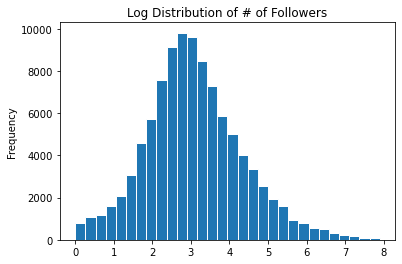

In [20]:
# plot the distribution of # of followers (log)
ax1=np.log10(tweets['#Followers']+1).plot(kind='hist', bins=30, edgecolor='w', title="Log Distribution of # of Followers")

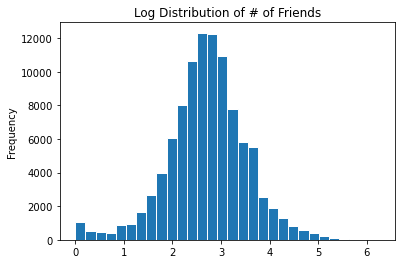

In [21]:
# distribution of # of friends (log)
np.log10(tweets['#Friends']+1).plot(kind='hist', bins=30, edgecolor='w', title='Log Distribution of # of Friends')

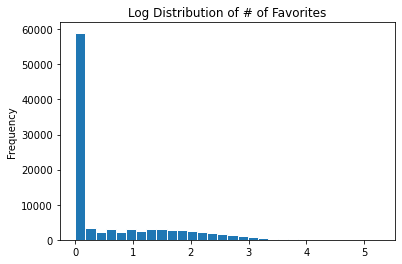

In [22]:
# distribution of # of favorites (log)
np.log10(tweets['#Favorites']+1).plot(kind='hist', bins=30, edgecolor='w', title='Log Distribution of # of Favorites')

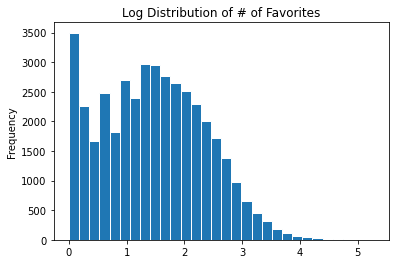

In [23]:
# distribution of # of favorites (log) without zeros 
np.log10(tweets['#Favorites'].replace(0, np.nan)).plot(kind='hist', bins=30, edgecolor='w', title='Log Distribution of # of Favorites')

In [24]:
corr=tweets[['#Favorites', '#Followers', '#Friends', 'Positive', 'Negative', '#Retweets']].corr()
corr

,#Favorites,#Followers,#Friends,Positive,Negative,#Retweets
#Favorites,1.000000,0.172158,0.017877,0.002533,-0.003889,0.890328
#Followers,0.172158,1.000000,0.011337,-0.027071,0.008711,0.134503
#Friends,0.017877,0.011337,1.000000,-0.000555,-0.007891,0.026502
Positive,0.002533,-0.027071,-0.000555,1.000000,-0.039849,0.000433
Negative,-0.003889,0.008711,-0.007891,-0.039849,1.000000,-0.010565
#Retweets,0.890328,0.134503,0.026502,0.000433,-0.010565,1.000000


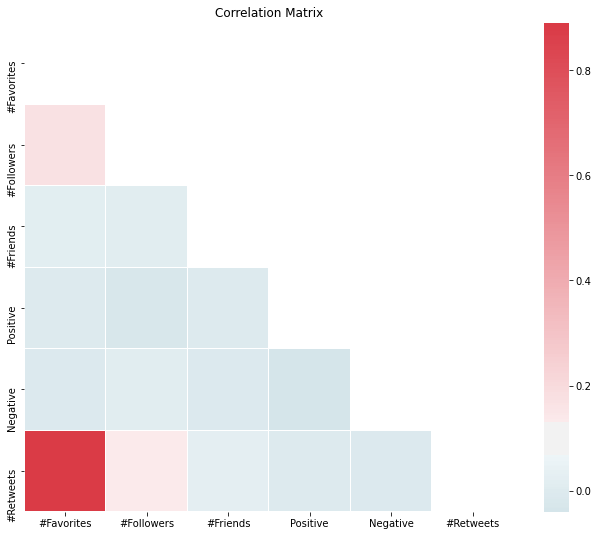

In [25]:
# visualize correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax.set_title('Correlation Matrix')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0.1,
            square=True, linewidths=.3)

#### Further prepare data; feature engineering

In [26]:
# hot encode dummy variables for top mentions
for i in top_mentions:
    tweets[i]=0
    tweets.loc[tweets['Mentions'].str.upper().str.contains(i), i]=1

In [27]:
tweets[tweets['REALDONALDTRUMP']==1]

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,...,REALDONALDTRUMP,JAKETAPPER,BTS_TWT,POTUS,YOUTUBE,CNN,NBA,SPEAKERPELOSI,GOP,LINDSEYGRAHAMSC
44,1178839076235042816,796ba585fdd57b9845a6b8f2e255b295,Tue Oct 01 01:08:32 +0000 2019,3044,1649,15,37,kayleigh:Kayleigh:-2.594869369680897;,1 -1,ScottPresler realDonaldTrump parscale kayleigh...,...,1,0,0,0,0,0,0,0,0,0
48,1178840722323066881,5bb9389f949f92d932ec0d9e16c2d775,Tue Oct 01 01:15:04 +0000 2019,744,781,0,0,null;,2 -1,realDonaldTrump,...,1,0,0,0,0,0,0,0,0,0
115,1178915942987747329,7db56f4d8c0583e6427a2a68bb8a4fd3,Tue Oct 01 06:13:58 +0000 2019,2602,3228,0,0,military parade:Military_parade:-1.91983861118...,1 -1,WSJ realDonaldTrump’s,...,1,0,0,0,0,0,0,0,0,0
117,1178916395943227394,4d63e951225790bde12399132edad552,Tue Oct 01 06:15:46 +0000 2019,34,125,0,0,makes me wonder:Makes_Me_Wonder:-1.20345439249...,1 -2,Snow_Flake2017 polamalurules43 PikachuSerena r...,...,1,0,0,0,0,0,0,0,0,0
144,1178952806704783360,01f7401a1bf8df4ecebe2e607c68a1a2,Tue Oct 01 08:40:27 +0000 2019,12,10,0,0,nicotine:Nicotine:-1.974112453329532;thc:Tetra...,2 -3,realDonaldTrump,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99896,1179468089529733120,27b1e9d18a530817c463043cbcfd52a6,Wed Oct 02 18:48:00 +0000 2019,704,3212,0,0,null;,2 -1,realDonaldTrump LindseyGrahamSC,...,1,0,0,0,0,0,0,0,0,1
99933,1179497465353035777,9bbac1b6b3a1c69ee40fe9842bedbaf1,Wed Oct 02 20:44:44 +0000 2019,1484,1192,1,0,null;,1 -4,realDonaldTrump TheDemocrats,...,1,0,0,0,0,0,0,0,0,0
99940,1179504647083442176,9091caa0c6b895e89c4b2f6eafa6bb59,Wed Oct 02 21:13:16 +0000 2019,196,605,0,0,ivanka trump:Ivanka_Trump:-0.9067480565627685;,1 -3,realDonaldTrump,...,1,0,0,0,0,0,0,0,0,0
99956,1179517695584276480,84ef473f81942797613eb5a06d73705a,Wed Oct 02 22:05:07 +0000 2019,479,925,0,0,hey there:Hey_There:-2.393598594279745;potus:P...,2 -2,realDonaldTrump potus.,...,1,0,0,1,0,0,0,0,0,0


In [28]:
# hot encode dummy vars for top hashtags
for i in top_hashtags:
    tweets[i]=0
    tweets.loc[tweets['Hashtags'].str.upper().str.contains(i), i]=1

In [29]:
# parse day and time information from date 
tweets['ts']=pd.to_datetime(tweets['Timestamp'])
tweets['hour']=tweets['ts'].dt.hour

In [30]:
def f(x):
    if (x > 6) and (x <= 12):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Afternoon'
    elif (x > 16) and (x <= 22) :
        return 'Evening'
    elif ((x > 22) and (x <= 24)) or ((0 <= x) and (x <= 2)):
        return'Night'
    elif (x<=6):
        return'Early Morning'

tweets['time_of_day']=tweets['hour'].apply(f)

In [31]:
tweets['day']=tweets['ts'].dt.weekday

In [32]:
def d(x):
    if (x>=0) and (x<=4):
        return 'Weekday'
    elif (x>4):
        return 'Weekend'
    
tweets['day_of_wk']=tweets['day'].apply(d)

In [33]:
tweets=pd.concat([tweets, pd.get_dummies(tweets['day_of_wk']), pd.get_dummies(tweets['time_of_day'])], axis=1)

In [34]:
tweets.head()

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,...,time_of_day,day,day_of_wk,Weekday,Weekend,Afternoon,Early Morning,Evening,Morning,Night
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,null;,2 -1,null;,...,Evening,0,Weekday,1,0,0,0,1,0,0
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,...,Evening,0,Weekday,1,0,0,0,1,0,0
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,...,Evening,0,Weekday,1,0,0,0,1,0,0
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,...,Evening,0,Weekday,1,0,0,0,1,0,0
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,...,Evening,0,Weekday,1,0,0,0,1,0,0


In [35]:
#next, parse out entities 
ent=tweets['Entities'].str.split(';').copy()

In [36]:
#the matched entities are between two : symbols in the string
pattern=':(.*?):'
ent1=[re.search(pattern, i.strip().upper()).group(1) for i in list(itertools.chain.from_iterable(ent.to_list())) if 'null' not in i and i !='']

In [37]:
entities_dict={x: count for x, count in Counter(ent1).items() if count >=10 and (x not in top_hashtags and x not in top_mentions)}

In [38]:
# take a look at the top matched entities:
top_ents=sorted(entities_dict, key=entities_dict.get, reverse=True)[:10]
for i in top_ents:
    print(i, ': ', entities_dict.get(i), sep='')

TWITTER: 2283
LOL: 1157
RAPPING: 1022
HONG_KONG: 808
WHAT%27S_HAPPENING%21%21: 765
REPUBLICAN_PARTY_%28UNITED_STATES%29: 762
BTS: 667
NATIONAL_BASKETBALL_ASSOCIATION: 555
BREXIT: 542
IMPEACHMENT: 502


In [39]:
# hot encode dummy variables for top entities
# note that there is some subject overlap (potential collinearity with top mentions/hashtags), will need to resolve that
for i in top_ents:
        tweets[i]=0
        tweets.loc[tweets['Entities'].str.upper().str.contains(i), i]=1

In [40]:
tweets.head(5)

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Entities,Sentiment,Mentions,...,TWITTER,LOL,RAPPING,HONG_KONG,WHAT%27S_HAPPENING%21%21,REPUBLICAN_PARTY_%28UNITED_STATES%29,BTS,NATIONAL_BASKETBALL_ASSOCIATION,BREXIT,IMPEACHMENT
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,null;,2 -1,null;,...,0,0,0,0,0,0,0,0,0,0
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,nazi:Nazism:-2.742538749414189;blood money:Blo...,1 -4,null;,...,0,0,0,0,0,0,0,0,0,0
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,...,0,0,0,0,0,0,0,0,0,0
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,muse:Muse_%28band%29:-2.1677823918620867;talki...,2 -1,null;,...,0,0,0,0,0,0,0,0,0,0
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,people of northern ireland:People_of_Northern_...,2 -1,null;,...,0,0,0,0,0,0,0,0,0,0


In [41]:
corr1=tweets[top_mentions + top_ents + top_hashtags].corr() 

In [42]:
print(corr1)

                                      REALDONALDTRUMP  JAKETAPPER   BTS_TWT  \
REALDONALDTRUMP                              1.000000    0.026036 -0.006865   
JAKETAPPER                                   0.026036    1.000000 -0.003964   
BTS_TWT                                     -0.006865   -0.003964  1.000000   
POTUS                                        0.130709    0.010633 -0.002711   
YOUTUBE                                     -0.001765   -0.003745  0.001593   
CNN                                          0.041350    0.261497 -0.003005   
NBA                                          0.006827   -0.003594  0.035619   
SPEAKERPELOSI                                0.099249    0.035594 -0.002220   
GOP                                          0.097545    0.011595 -0.003234   
LINDSEYGRAHAMSC                              0.051764    0.013198 -0.002041   
TWITTER                                      0.008140   -0.001020 -0.000408   
LOL                                         -0.00434

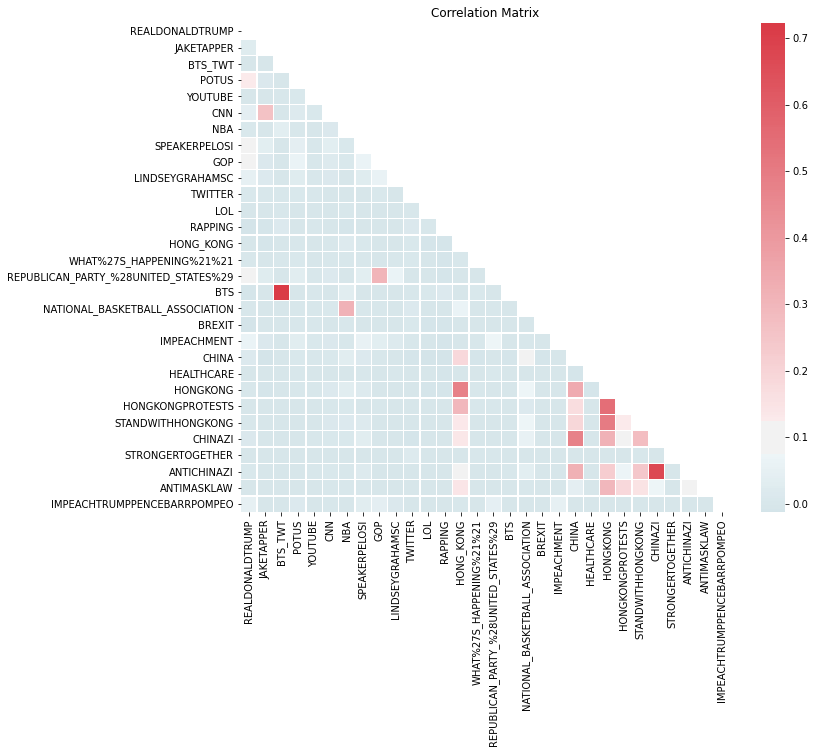

In [43]:
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax.set_title('Correlation Matrix')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, center=0.1,
            square=True, linewidths=.3)

In [44]:
# the highly correlated text features are BTS/BTS_TWT, HONGKONGPROTEST/HONGKONG ANTICHINAZI/CHINAZI, STANDWITHHONGKONG/HONGKONG
# drop subset of these features to reduce issue of multicollinearity
cleaned_tweets=tweets.drop(['BTS_TWT', 'HONGKONG', 'HONG_KONG', 'CHINAZI'], axis=1).copy()

In [45]:
# drop mention and hashtag variables, along with url and sentiment  
cleaned_tweets.drop(['Hashtags','Timestamp', 'Entities', 'Mentions', 'Tweet ID', 'Username', 'Sentiment', 'URLs', 'day_of_wk', 'time_of_day', 'hour', 'day', 'ts'], axis=1, inplace=True)

In [46]:
# check for null values
cleaned_tweets.isnull().sum()

#Followers                              0
#Friends                                0
#Retweets                               0
#Favorites                              0
Positive                                0
Negative                                0
#Mentions                               0
#Hashtags                               0
REALDONALDTRUMP                         0
JAKETAPPER                              0
POTUS                                   0
YOUTUBE                                 0
CNN                                     0
NBA                                     0
SPEAKERPELOSI                           0
GOP                                     0
LINDSEYGRAHAMSC                         0
CHINA                                   0
HEALTHCARE                              0
HONGKONGPROTESTS                        0
STANDWITHHONGKONG                       0
STRONGERTOGETHER                        0
ANTICHINAZI                             0
ANTIMASKLAW                       

In [47]:
features=cleaned_tweets.columns.tolist()
features.remove('#Retweets')

In [48]:
features

['#Followers',
 '#Friends',
 '#Favorites',
 'Positive',
 'Negative',
 '#Mentions',
 '#Hashtags',
 'REALDONALDTRUMP',
 'JAKETAPPER',
 'POTUS',
 'YOUTUBE',
 'CNN',
 'NBA',
 'SPEAKERPELOSI',
 'GOP',
 'LINDSEYGRAHAMSC',
 'CHINA',
 'HEALTHCARE',
 'HONGKONGPROTESTS',
 'STANDWITHHONGKONG',
 'STRONGERTOGETHER',
 'ANTICHINAZI',
 'ANTIMASKLAW',
 'IMPEACHTRUMPPENCEBARRPOMPEO',
 'Weekday',
 'Weekend',
 'Afternoon',
 'Early Morning',
 'Evening',
 'Morning',
 'Night',
 'TWITTER',
 'LOL',
 'RAPPING',
 'WHAT%27S_HAPPENING%21%21',
 'REPUBLICAN_PARTY_%28UNITED_STATES%29',
 'BTS',
 'NATIONAL_BASKETBALL_ASSOCIATION',
 'BREXIT',
 'IMPEACHMENT']

In [49]:
cleaned_tweets.dtypes

#Followers                                int64
#Friends                                  int64
#Retweets                                 int64
#Favorites                                int64
Positive                                  int32
Negative                                  int32
#Mentions                               float64
#Hashtags                               float64
REALDONALDTRUMP                           int64
JAKETAPPER                                int64
POTUS                                     int64
YOUTUBE                                   int64
CNN                                       int64
NBA                                       int64
SPEAKERPELOSI                             int64
GOP                                       int64
LINDSEYGRAHAMSC                           int64
CHINA                                     int64
HEALTHCARE                                int64
HONGKONGPROTESTS                          int64
STANDWITHHONGKONG                       

#### Run models for prediction

In [50]:
# first get a sense of the distribution of the outcome variable
cleaned_tweets['#Retweets'].describe()

count    100000.000000
mean         33.442620
std         408.883046
min           0.000000
25%           0.000000
50%           0.000000
75%           6.000000
max       79364.000000
Name: #Retweets, dtype: float64

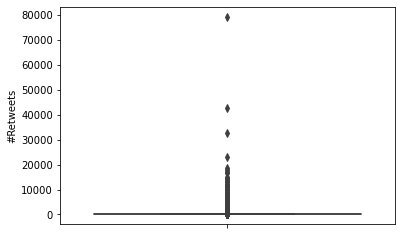

In [51]:
sns.boxplot(y=cleaned_tweets['#Retweets'])

# note that there is one extreme outlier with 79364 retweets
# after consideration, this outlier will not be removed from the data as it is a natural part of the variability of the dataset (i.e. not caused by measurement or data entry errors)
# note that this may decrese the R-squared of our predictor models 

In [52]:
X=cleaned_tweets[features]
y=cleaned_tweets['#Retweets']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)

In [53]:
# because there are a lot of binary variables in the features, scale the data using fit_transform

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [54]:
def adj_r2(y_test, y_pred):
    adj = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1))
    return adj

In [55]:
# try linear regression as baseline 

lin_reg=LinearRegression()
lin_reg.fit(X_train, y_train)
y_prediction=lin_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the linear model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

The RMSE of the linear model is: 184.62089305163255
The R2 is: 0.5332952254263219
The adjusted R2 is: 0.5323598984568871


In [56]:
# try lasso regression

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
y_prediction = lasso_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the lasso model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

The RMSE of the lasso model is: 183.9825912353388
The R2 is: 0.5365167842481111
The adjusted R2 is: 0.535587913631844


In [57]:
# try a ridge regression

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
y_prediction = ridge_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the ridge model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

The RMSE of the ridge model is: 184.61816371137485
The R2 is: 0.5333090243706673
The adjusted R2 is: 0.5323737250558132


In [58]:
# Decision tree:

tree=DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_prediction=tree.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the decision tree model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

The RMSE of the decision tree model is: 186.96170842434586
The R2 is: 0.5213854634777408
The adjusted R2 is: 0.5204262680540778


In [59]:
# Random forest:

rd_forest=RandomForestRegressor(max_depth=10)
rd_forest.fit(X_train, y_train)
y_prediction=rd_forest.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the random forest model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

The RMSE of the random forest model is: 160.41255849791213
The R2 is: 0.6476637884087859
The adjusted R2 is: 0.6469576684396667


Best model as evaluated by RMSE:

In [60]:
# try using XGboost: 

XGB_reg = XGBRegressor(booster='gbtree')
XGB_reg.fit(X_train, y_train)
y_prediction=XGB_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the XGboost model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

#NOTE: this is the best performing model that minimizes RMSE
#R2 is not very high, indicating that there is still a portion of variability in the outcome that is not explained by the model 

The RMSE of the XGboost model is: 153.72559905797323
The R2 is: 0.6764265068710451
The adjusted R2 is: 0.6757780305082435


In [61]:
# try using XGboost linear: 

XGB_reg = XGBRegressor(booster='gblinear')
XGB_reg.fit(X_train, y_train)
y_prediction=XGB_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the XGBoost linear model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

The RMSE of the XGBoost linear model is: 184.62067018202328
The R2 is: 0.5332963522137211
The adjusted R2 is: 0.5323610275024904


In [62]:
# lastly, try PCA then linear regression

pca=make_pipeline(PCA(n_components=5), LinearRegression())
pca.fit(X_train, y_train)
y_prediction=pca.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
r2=r2_score(y_true = y_test, y_pred = y_prediction)
print("The RMSE of the PCA + linear model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test, y_prediction))

The RMSE of the PCA + linear model is: 269.60390194369796
The R2 is: 0.004748373786540028
The adjusted R2 is: 0.0027537816201719245


In [63]:
# the extra features added for entity, mention, and hashtag flags may be causing overfitting 
# and subsequent large RMSE errors in prediction
# to remedy this issue, try combining the entity, mention, and hashtag columns into a raw score column 
# for example, sum the number of mentions in a tweet that was in the top 10 mention list 

cleaned2=cleaned_tweets.copy()

In [64]:
cleaned2['mentions_score']=0
for i in top_mentions:
    if i in cleaned2.columns:
        cleaned2['mentions_score']+=cleaned2[i]

In [65]:
cleaned2['hashtags_score']=0
for i in top_hashtags:
    if i in cleaned2.columns:
        cleaned2['hashtags_score']+=cleaned2[i]

In [66]:
cleaned2['entities_score']=0
for i in top_ents:
    if i in cleaned2.columns:
        cleaned2['entities_score']+=cleaned2[i]

In [67]:
cleaned2.columns

Index(['#Followers', '#Friends', '#Retweets', '#Favorites', 'Positive',
       'Negative', '#Mentions', '#Hashtags', 'REALDONALDTRUMP', 'JAKETAPPER',
       'POTUS', 'YOUTUBE', 'CNN', 'NBA', 'SPEAKERPELOSI', 'GOP',
       'LINDSEYGRAHAMSC', 'CHINA', 'HEALTHCARE', 'HONGKONGPROTESTS',
       'STANDWITHHONGKONG', 'STRONGERTOGETHER', 'ANTICHINAZI', 'ANTIMASKLAW',
       'IMPEACHTRUMPPENCEBARRPOMPEO', 'Weekday', 'Weekend', 'Afternoon',
       'Early Morning', 'Evening', 'Morning', 'Night', 'TWITTER', 'LOL',
       'RAPPING', 'WHAT%27S_HAPPENING%21%21',
       'REPUBLICAN_PARTY_%28UNITED_STATES%29', 'BTS',
       'NATIONAL_BASKETBALL_ASSOCIATION', 'BREXIT', 'IMPEACHMENT',
       'mentions_score', 'hashtags_score', 'entities_score'],
      dtype='object')

In [68]:
feats2=['#Followers', '#Friends', '#Favorites', 'Positive', 'Negative', '#Mentions','#Hashtags', 'Weekday', 'Weekend', 'Afternoon', 'Night', 'Early Morning', 'Morning', 'mentions_score', 'entities_score', 'hashtags_score']


In [69]:
X2=cleaned2[feats2]
y2=cleaned2['#Retweets']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=142)
sc2 = StandardScaler()
X_train2 = sc2.fit_transform(X_train2)
X_test2 = sc2.transform (X_test2)

In [70]:
# linear regression

lin_reg=LinearRegression()
lin_reg.fit(X_train2, y_train2)
y_prediction=lin_reg.predict(X_test2)
RMSE = sqrt(mean_squared_error(y_true = y_test2, y_pred = y_prediction))
r2=r2_score(y_true = y_test2, y_pred = y_prediction)
print("The RMSE of the linear model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test2, y_prediction))

The RMSE of the linear model is: 184.6217284696316
The R2 is: 0.5332910016957935
The adjusted R2 is: 0.5323556662615447


In [71]:
# ridge regression
ridge_reg = Ridge()
ridge_reg.fit(X_train2, y_train2)
y_prediction = ridge_reg.predict(X_test2)
RMSE = sqrt(mean_squared_error(y_true = y_test2, y_pred = y_prediction))
r2=r2_score(y_true = y_test2, y_pred = y_prediction)
print("The RMSE of the ridge model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test2, y_prediction))

The RMSE of the ridge model is: 184.61922955634836
The R2 is: 0.5333036357170655
The adjusted R2 is: 0.5323683256027654


In [72]:
# Random forest

rd_forest=RandomForestRegressor(max_depth=10)
rd_forest.fit(X_train2, y_train2)
y_prediction=rd_forest.predict(X_test2)
RMSE = sqrt(mean_squared_error(y_true = y_test2, y_pred = y_prediction))
r2=r2_score(y_true = y_test2, y_pred = y_prediction)
print("The RMSE of the random forest model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test2, y_prediction))

The RMSE of the random forest model is: 161.0640133686736
The R2 is: 0.6447962171880197
The adjusted R2 is: 0.6440843502952656


In [73]:
# try using XGboost 

XGB_reg2 = XGBRegressor(booster='gbtree')
XGB_reg2.fit(X_train2, y_train2)
y_prediction=XGB_reg2.predict(X_test2)
RMSE = sqrt(mean_squared_error(y_true = y_test2, y_pred = y_prediction))
r2=r2_score(y_true = y_test2, y_pred = y_prediction)
print("The RMSE of the XGboost model is:", RMSE)
print("The R2 is:", r2)
print("The adjusted R2 is:", adj_r2(y_test2, y_prediction))

The RMSE of the XGboost model is: 156.74772840273732
The R2 is: 0.6635790285614547
The adjusted R2 is: 0.6629048044591679
